# Sparkify Project
This data contains key insights in maintaining user happy service. Our task in this project is to develop a model that predict which users have potential to cancel premium services, etc...
My work will give business more chances to provide suitable service to their customers.


I have prepared several insighs research to clarify throughout the project. You can find out at step `Feature Engineering` 
1. What is the total number of thumbs down by users for each churn?
2. And the opposite, How many thumbs up of the users?
3. Find out the number of errors that users encountered

# Import Libraries

In [1]:
# Data processing
import pandas as pd

# Data visualizing
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark data processing 
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType

# PySpark Machine Learning
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

- And i will create a Spark Session here named Project_Sparkify

In [2]:
# create a Spark session
spark = SparkSession.builder \
                    .master("local") \
                    .appName("Project_Sparkify") \
                    .getOrCreate()

# Load and Clean Dataset

In [3]:
# Load JSON dataset into Spark DataFrame
content = 'mini_sparkify_event_data.json'
df = spark.read.json(content)

In [4]:
# Test
df.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


- I check the schema of this JSON file

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



**Because all variables are in the right form of data type, i do not need to perform any data type transformations**

# Exploratory Data Analysis

- In this part, i will find out if this dataset has duplicates or null values. Besides that, i also find another statistics of this dataset for better processing

In [6]:
df.toPandas().describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


- Check null records in this dataset

In [7]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96ddd2dfd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f96d018b7b8>]], dtype=object)

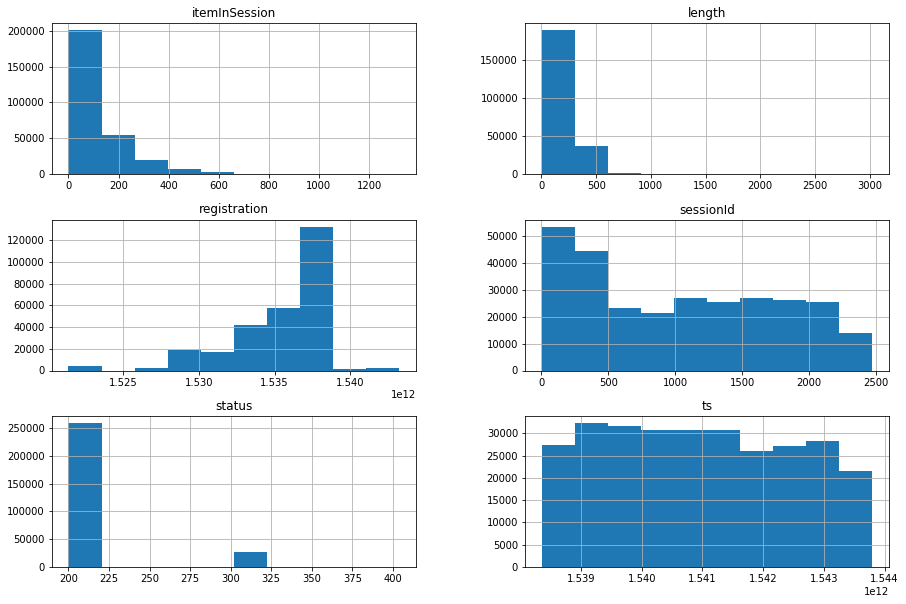

In [8]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
df.toPandas().hist(ax = ax)

- Print out list of unique values of column `page` with no duplicates

In [9]:
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



- Print out all values of column `level` with 2 values free and paid, which can be considered to be valuable feature for ML model

In [10]:
df.select('level').dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



- Check null values in column `sessionId`. If not null, it will print out a conclusion statement

In [11]:
sessionId_list = df.toPandas()['sessionId'].unique().tolist()
for item in sessionId_list:
    if item == '': 
        print("Detect empty values!")
        break;
    elif item != '': 
        print("Do not detect any empty values!")
        break;

Do not detect any empty values!


- Remove all rows that have userId and sessionId missing

In [12]:
drop_missings_df = df.dropna(subset = ["userId", "sessionId"])

- Filter all rows that have userId

In [13]:
drop_missings_df = drop_missings_df.filter(drop_missings_df["userId"] != "")

- Finally, convert this DataFrame in to Pandas DataFrame for easier querying or visualizing

In [14]:
cleaned_df = drop_missings_df.toPandas()

In the next step, i will find out churned users. A churned user is a user that commit `Submit Downgrade` or `Cancellation Confirmation`

In [15]:
churned_users_list = list(cleaned_df[cleaned_df['page'] == 'Submit Downgrade']['userId'].unique())
churned_users_list.extend(list(cleaned_df[cleaned_df['page'] == 'Cancellation Confirmation']['userId'].unique()))

In [16]:
churned_users_list = list(set(churned_users_list))

In [17]:
# Test
churned_users_list

['39',
 '129',
 '200016',
 '51',
 '100009',
 '200018',
 '103',
 '100007',
 '122',
 '106',
 '200021',
 '96',
 '300002',
 '100019',
 '3',
 '141',
 '200009',
 '300023',
 '61',
 '53',
 '100013',
 '200001',
 '12',
 '13',
 '100',
 '28',
 '25',
 '200015',
 '87',
 '300004',
 '143',
 '85',
 '300021',
 '200011',
 '200019',
 '100024',
 '200023',
 '100008',
 '200025',
 '100016',
 '17',
 '125',
 '131',
 '300001',
 '100017',
 '35',
 '200020',
 '100004',
 '70',
 '100011',
 '300011',
 '9',
 '58',
 '109',
 '140',
 '300015',
 '95',
 '101',
 '59',
 '100015',
 '77',
 '100003',
 '100022',
 '100001',
 '100021',
 '105',
 '100005',
 '38',
 '30',
 '300007',
 '49',
 '100018',
 '100023',
 '100014',
 '92',
 '100012',
 '24',
 '200024',
 '81',
 '29',
 '11',
 '20',
 '200017',
 '100025',
 '54',
 '100006',
 '200003',
 '74',
 '18',
 '121',
 '73',
 '32']

Combine userId and gender of user into one DataFrame, respected to churn

In [18]:
unique_userids_list = cleaned_df['userId'].unique().tolist()
gender = []
for userid in unique_userids_list:
    gender.append(cleaned_df[cleaned_df['userId'] == userid]['gender'].iloc[0])

Combining step

In [19]:
userid_gender_df = pd.DataFrame({'userId': unique_userids_list, 'gender': gender})

- Apply map to fill in churn values. If userId in unique_userids_list then churn is 1, another is 0

In [20]:
userid_gender_df['churn'] = userid_gender_df['userId'].apply(lambda x: 1 if x in churned_users_list else 0)

In [21]:
# Test
userid_gender_df.head(5)

,userId,gender,churn
0,30,M,1
1,9,M,1
2,74,F,1
3,54,F,1
4,4,M,0


Visualizing results using Seaborn library

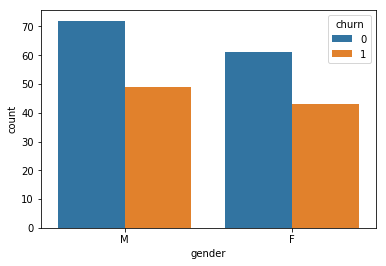

In [22]:
sns.countplot(x = "gender", hue = "churn", data = userid_gender_df)

Likes above, i will do the same steps for userId and customer level

In [23]:
level = []
for userid in unique_userids_list:
    level.append(cleaned_df[cleaned_df['userId'] == userid]['level'].iloc[0])
userid_level_df = pd.DataFrame({'userId': unique_userids_list, 'level': level})
userid_level_df['churn'] = userid_level_df['userId'].apply(lambda x: 1 if x in churned_users_list else 0)

In [24]:
# Test
userid_level_df.head()

,userId,level,churn
0,30,paid,1
1,9,free,1
2,74,free,1
3,54,paid,1
4,4,free,0


- Visualizing results

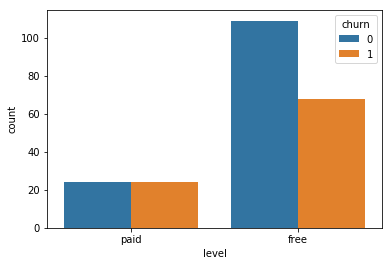

In [25]:
sns.countplot(x = "level", hue = "churn", data = userid_level_df)

**It is also the last step of Exploratory Data Analysis part. In order to move to next part, i will create a Spark View named sparkify_db**

In [26]:
drop_missings_df.createOrReplaceTempView("sparkify_db")

# Feature Engineering

In this part, i will try to answer all insight questions to find out which features can be used in ML model

### 1. What is the total number of thumbs down by users for each churn?

- Query all users that have given thumbs down with total number of giving

In [27]:
thumb_down_user_query = spark.sql("SELECT userId, count(*) as count_thumb_down_users \
                        FROM sparkify_db \
                        where page = 'Thumbs Down' \
                        group by userId")

- Convert it into Pandas DataFrame

In [28]:
thumb_down_user_pd = thumb_down_user_query.toPandas()

- Apply map to fill in column `churn` value

In [29]:
thumb_down_user_pd['churn'] = thumb_down_user_pd['userId'].apply(lambda x: 1 if x in churned_users_list else 0)

- Visualizing results

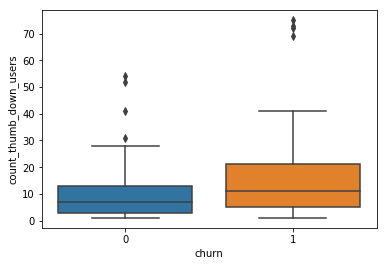

In [30]:
sns.boxplot(x="churn", y="count_thumb_down_users", data=thumb_down_user_pd)

### 2. And the opposite, How many thumbs up of the users?

In [31]:
thumb_up_user_query = spark.sql("SELECT userId, count(*) as count_thumb_up_users \
                      FROM sparkify_db \
                      where page = 'Thumbs Up' \
                      group by userId")

Convert into Pandas DataFrame

In [32]:
thumb_up_user_pd = thumb_up_user_query.toPandas()

- Apply map to fill in column churn based on userId

In [33]:
thumb_up_user_pd['churn'] = thumb_up_user_pd['userId'].apply(lambda x: 1 if x in churned_users_list else 0)

- Visualizing results

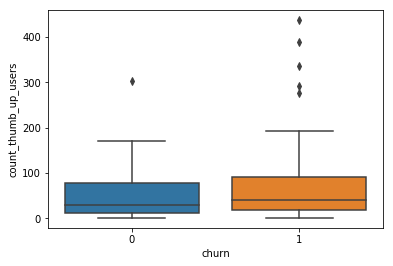

In [34]:
sns.boxplot(x="churn", y="count_thumb_up_users", data=thumb_up_user_pd)

### 3. Find out the number of errors that users encountered

In [35]:
count_errors = spark.sql("SELECT userId, count(*) as count_errors \
                   FROM sparkify_db \
                   WHERE page = 'Error' \
                   GROUP BY userId")

In [36]:
count_errors_pd = count_errors.toPandas()

In [37]:
count_errors_pd['churn'] = count_errors_pd['userId'].apply(lambda x: 1 if x in churned_users_list else 0)

- Visualizing results

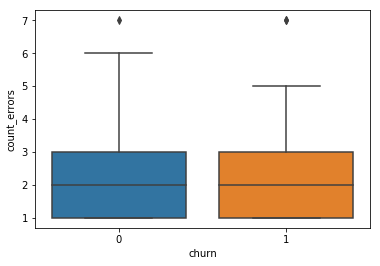

In [38]:
sns.boxplot(x="churn", y="count_errors", data=count_errors_pd)

Next, i will try to clasify which user is churn with a new table

In [39]:
# Churn is defined when a user performs "Submit Downgrade" or "Cancellation Confirmation"
flag_downgrade_event = udf(lambda x: 1 if (x == "Submit Downgrade" or x == 'Cancellation Confirmation') else 0, IntegerType())

In [40]:
churned_users_query = spark.sql("SELECT userId, CASE \
                                WHEN page = 'Submit Downgrade' OR page = 'Cancellation Confirmation' \
                                THEN 1 \
                                END AS churn \
                                FROM sparkify_db")

In [41]:
# Create a Spark View
churned_users_query.createOrReplaceTempView('churned_users_table')

In [42]:
# Get all user records that have churn not null
not_null_churn = spark.sql("SELECT * FROM churned_users_table \
                           WHERE churn IS NOT null")
not_null_churn.createOrReplaceTempView('churned_users')

In [43]:
# Result
spark.sql("SELECT * FROM churned_users").show()

+------+-----+
|userId|churn|
+------+-----+
|   131|    1|
|    38|    1|
|   141|    1|
|    18|    1|
|    30|    1|
|    20|    1|
|    32|    1|
|    12|    1|
|    11|    1|
|    61|    1|
|    81|    1|
|   125|    1|
|    85|    1|
|   140|    1|
|   105|    1|
|    17|    1|
|    35|    1|
|   143|    1|
|    54|    1|
|    77|    1|
+------+-----+
only showing top 20 rows



It is time to combine all tables we have created into 1 unified DataFrame

In [44]:
joined_table1 = thumb_down_user_query.join(thumb_up_user_query, thumb_down_user_query.userId == thumb_up_user_query.userId).drop(thumb_up_user_query.userId)
joined_table2 = joined_table1.join(count_errors, count_errors.userId == joined_table1.userId).drop(count_errors.userId)

In [45]:
joined_table3 = joined_table2.join(not_null_churn, not_null_churn.userId == joined_table2.userId, "left_outer").drop(not_null_churn.userId)

In [46]:
joined_table3.createOrReplaceTempView('joined_table')

- After creating Spark View joined_table, i filled in churn column values of the joined_table and finish the final joined DataFrame

In [47]:
final_df = spark.sql("SELECT userId, count_thumb_down_users, count_thumb_up_users, count_errors, CASE \
                    WHEN churn is null THEN 0 \
                    ELSE 1 END AS label \
                    FROM joined_table")

In [48]:
final_df.show()

+------+----------------------+--------------------+------------+-----+
|userId|count_thumb_down_users|count_thumb_up_users|count_errors|label|
+------+----------------------+--------------------+------------+-----+
|   124|                    41|                 171|           6|    0|
|    51|                    21|                 100|           1|    1|
|     7|                     1|                   7|           1|    0|
|    15|                    14|                  81|           2|    0|
|    54|                    29|                 163|           1|    1|
|    54|                    29|                 163|           1|    1|
|   155|                     3|                  58|           3|    0|
|   132|                    17|                  96|           3|    0|
|   101|                    16|                  86|           3|    1|
|    11|                     9|                  40|           1|    1|
|   138|                    24|                  95|           1

# Modeling
In this part, i will use all features that i hvae found into ML Model using Logistic Regression and calculate F1-score

In [49]:
# Split into training and testing dataset
train, test = final_df.randomSplit([0.9, 0.1], seed=42)

- Next, i will initialize assembler vector and min max scaler based on chose input columns

In [50]:
input_cols = ['count_thumb_down_users', 'count_thumb_up_users', 'count_errors']

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scalered_features")

- Logistic Regression pipeline initialization

In [51]:
lr =  LogisticRegression(labelCol="label", featuresCol="scalered_features", maxIter=10, regParam=0.0, elasticNetParam=0)

model_pipeline = Pipeline(stages=[assembler, scaler, lr])

- Build up parameter grid and cross validation for Logistic Regression

In [52]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()

crossval_lr = CrossValidator(estimator=model_pipeline,
                             estimatorParamMaps=paramGrid,
                             evaluator=MulticlassClassificationEvaluator(),
                             numFolds=3)

- Fit training and transform with tesitng dataset

In [53]:
model_lr = crossval_lr.fit(train)
model_lr.avgMetrics
result_lr = model_lr.transform(test)

- Measurement parameters

In [55]:
evaluator = MulticlassClassificationEvaluator(metricName="f1")
f1_score = evaluator.evaluate(result_lr)
accuracy = result_lr.filter(result_lr.label == result_lr.prediction).count()/ result_lr.count()

- Result

In [56]:
print("Accuracy: ", accuracy)
print("F1-score", f1_score)

Accuracy:  0.6
F1-score 0.638095238095238


# Conclusion
In the end of project, i want to summarize my work throughout entire Capstone Project

1. Load the dataset into Apache Spark
2. Check data quality (duplicates, NaN records,...)
3. Choose features for building ML model. At the present, i have chosen 3 features that valuable for model
4. Use Logistic Regression to find the best hyperparameters and the model with chosen features
5. Give F1-score and another measurement parameters for the chosen algorithm

Choose features for the algorithm is not an easy work, For an improved version in the future, i will find out more features that can be used in ML model for better performance.

# Credits
Many thanks to Udacity staffs for giving me workspace and valuable resources to complete my Udacity Data Scientist Degree. I wish you a happy new year :3 Cheers